In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data_folder = r"E:\spot_volume"

# 获取所有 CSV 文件
csv_files = [f for f in os.listdir(data_folder) if f.endswith(".csv")]

# 用于存储每个交易所对应的 DataFrame
dfs_by_exchange = {}

# 遍历 CSV 文件
for file in csv_files:
    file_path = os.path.join(data_folder, file)
    # 假设文件名格式为 "{market}_spot_volume_2000h.csv"
    market = file.split("_spot_volume_2000h.csv")[0]
    df = pd.read_csv(file_path)
    dfs_by_exchange[market] = df
    print(f"✅ 读取 {market} 数据成功，记录数：{len(df)}")


✅ 读取 binanceaggregate 数据成功，记录数：1002625
✅ 读取 binanceusa 数据成功，记录数：328207
✅ 读取 binance 数据成功，记录数：1002568
✅ 读取 bingx 数据成功，记录数：1704062
✅ 读取 bitfinex 数据成功，记录数：490852
✅ 读取 bitget 数据成功，记录数：1446788
✅ 读取 bitmex 数据成功，记录数：30000
✅ 读取 bitstamp 数据成功，记录数：228050
✅ 读取 bybit 数据成功，记录数：1085080
✅ 读取 coinbaseinternational 数据成功，记录数：4000
✅ 读取 coinbase 数据成功，记录数：617652
✅ 读取 gateio 数据成功，记录数：4411822
✅ 读取 gemini 数据成功，记录数：165383
✅ 读取 kraken 数据成功，记录数：725011
✅ 读取 kucoin 数据成功，记录数：1634340
✅ 读取 okex 数据成功，记录数：1100501
✅ 读取 upbit 数据成功，记录数：423050


In [5]:
# 目标币种
target_instrument = "BTC-USDT"

# 用于存储所有交易所的目标币种数据
all_exchanges_data = []

# 遍历每个交易所的数据
for market, df in dfs_by_exchange.items():
    # 过滤目标币种
    df_filtered = df[df["instrument"] == target_instrument].copy()
    # 添加交易所列
    df_filtered["exchange"] = market
    # 添加到列表中
    all_exchanges_data.append(df_filtered)

# 合并所有交易所的数据
combined_data = pd.concat(all_exchanges_data)

# 转换时间列为 datetime 类型
combined_data["time"] = pd.to_datetime(combined_data["time"])

print(f"✅ 合并数据成功，总记录数：{len(combined_data)}")

✅ 合并数据成功，总记录数：32000


In [ ]:
# 按交易所和时间窗口（每小时）聚合交易量
hourly_volume = combined_data.groupby(["exchange", pd.Grouper(key="time", freq="h")])["volume"].sum().reset_index()

print(hourly_volume.head())

  exchange                time      volume
0  binance 2024-11-26 23:00:00  1313.35950
1  binance 2024-11-27 00:00:00  1258.85709
2  binance 2024-11-27 01:00:00  1552.30509
3  binance 2024-11-27 02:00:00  1337.36368
4  binance 2024-11-27 03:00:00  1407.05432


C:\Users\HUAWEI\AppData\Local\Temp\ipykernel_30656\2913999633.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_volume = combined_data.groupby(["exchange", pd.Grouper(key="time", freq="H")])["volume"].sum().reset_index()


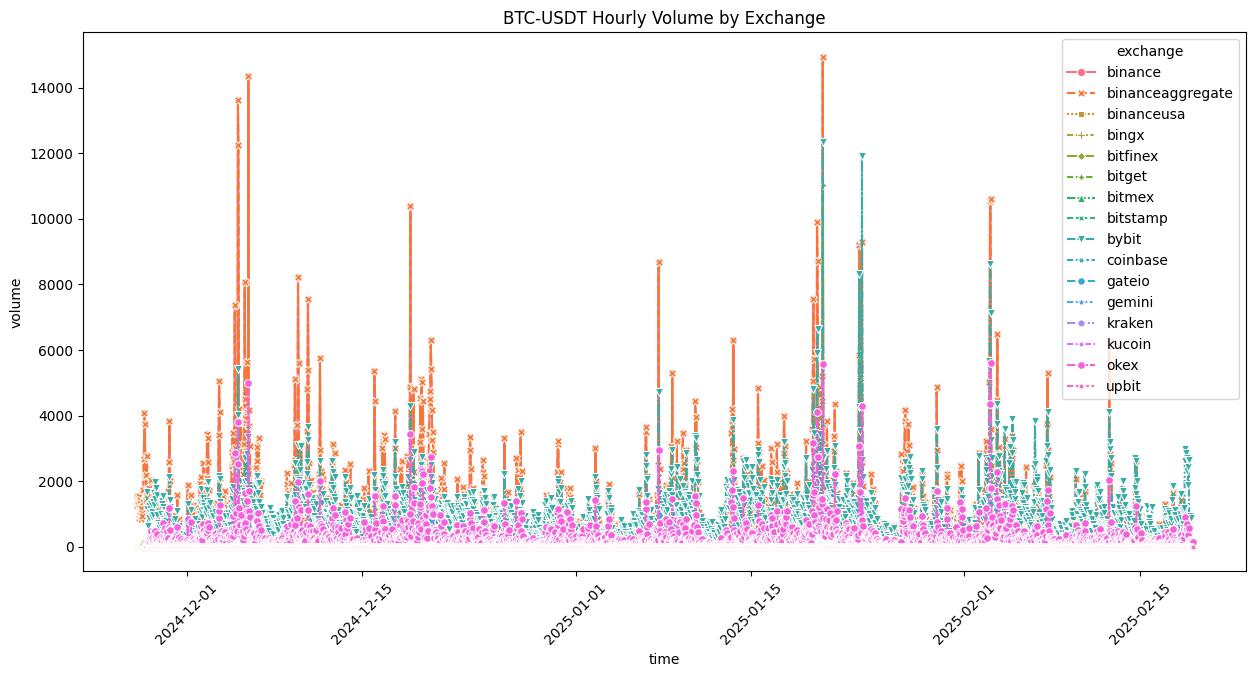

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 7))
sns.lineplot(
    data=hourly_volume,
    x="time",
    y="volume",
    hue="exchange",
    style="exchange",
    markers=True
)
plt.title(f"{target_instrument} Hourly Volume by Exchange")
plt.xticks(rotation=45)
plt.show()

d:\python\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


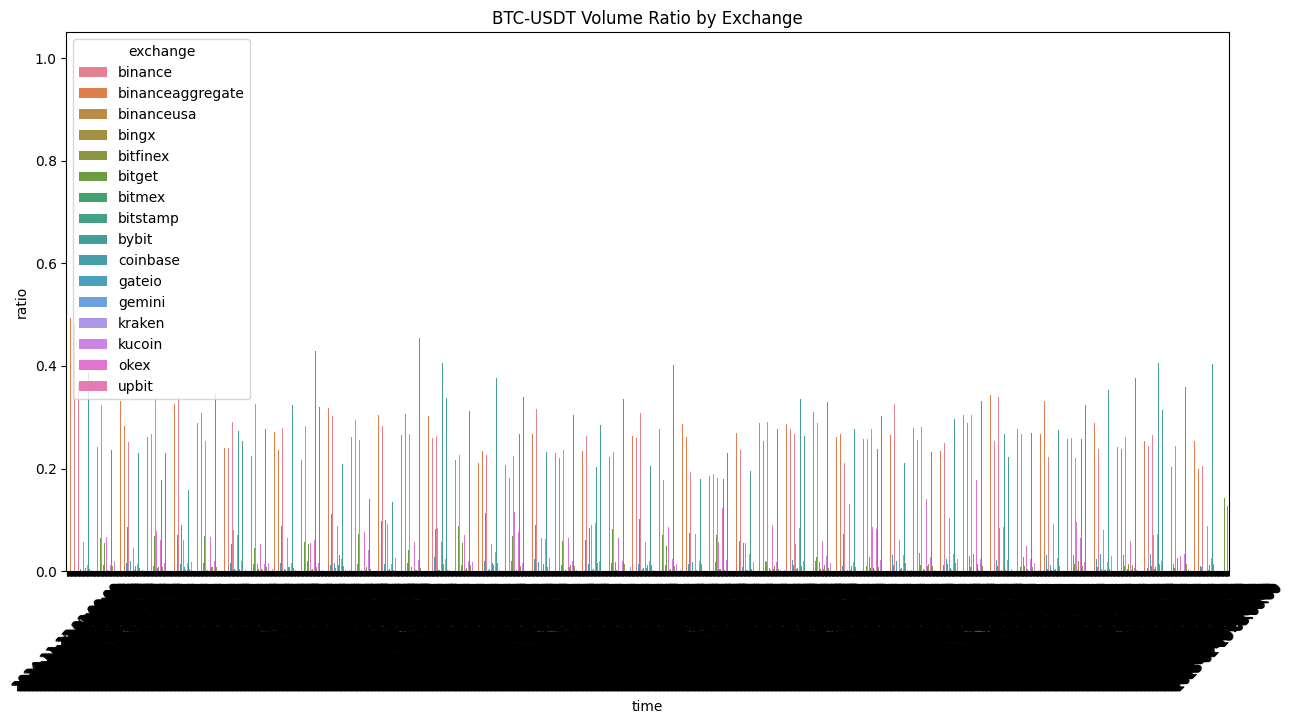

In [8]:
# 按时间窗口计算总交易量
total_volume = hourly_volume.groupby("time")["volume"].sum().reset_index(name="total_volume")

# 计算每个交易所的占比
hourly_volume_ratio = pd.merge(hourly_volume, total_volume, on="time")
hourly_volume_ratio["ratio"] = hourly_volume_ratio["volume"] / hourly_volume_ratio["total_volume"]

# 绘制占比图
plt.figure(figsize=(15, 7))
sns.barplot(
    data=hourly_volume_ratio,
    x="time",
    y="ratio",
    hue="exchange"
)
plt.title(f"{target_instrument} Volume Ratio by Exchange")
plt.xticks(rotation=45)
plt.show()

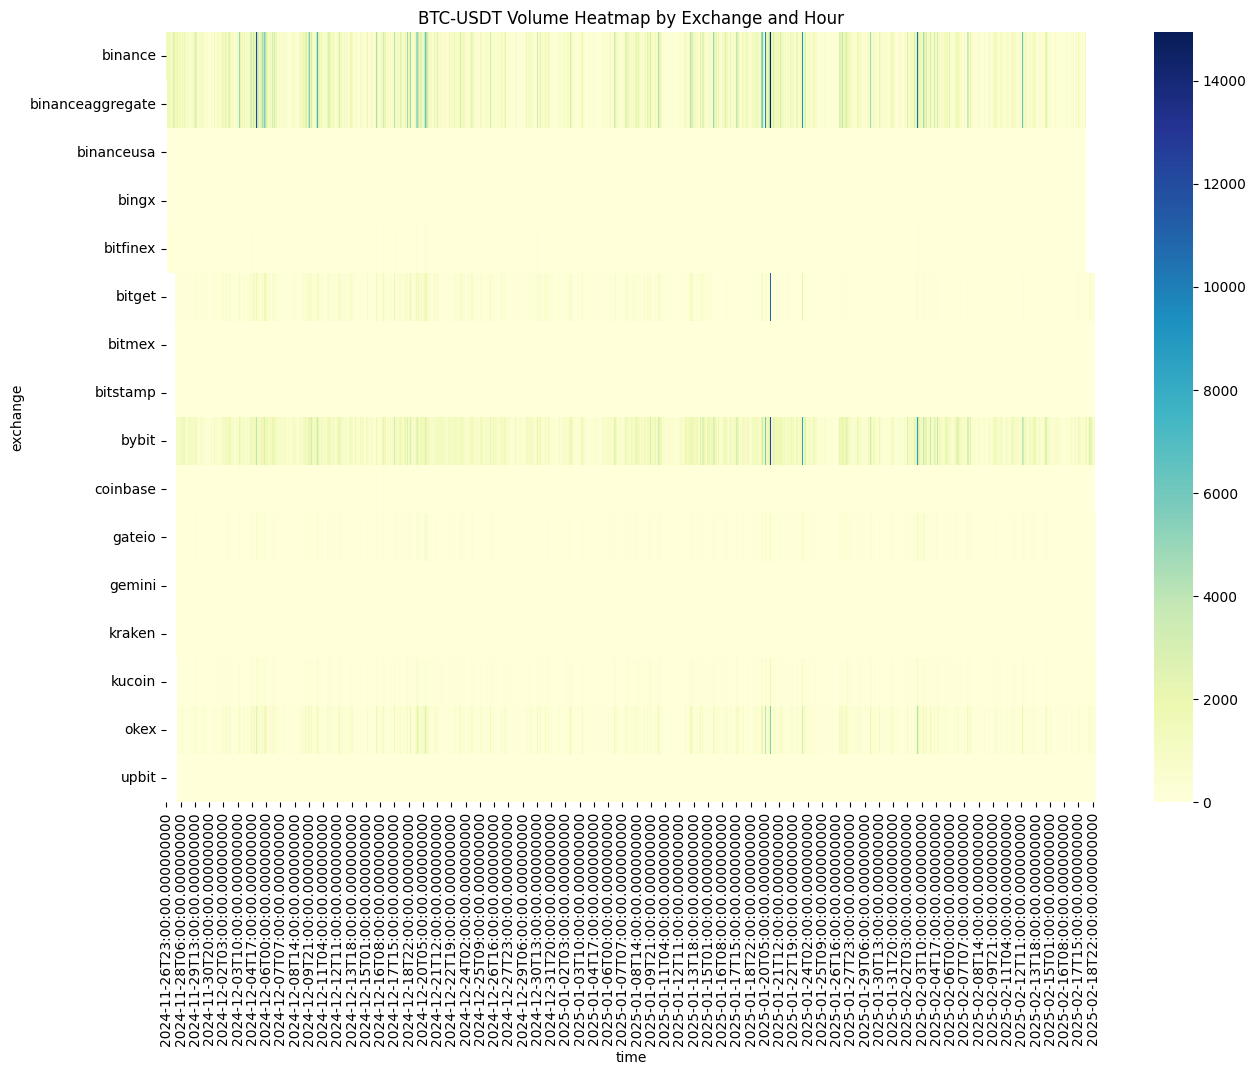

In [9]:
# 将数据转换为宽格式（交易所为列，时间为行）
pivot = hourly_volume.pivot(index="time", columns="exchange", values="volume")

# 绘制热力图
plt.figure(figsize=(15, 10))
sns.heatmap(pivot.T, cmap="YlGnBu")  # 转置矩阵以交易所为行
plt.title(f"{target_instrument} Volume Heatmap by Exchange and Hour")
plt.show()

In [10]:
# 示例：计算 BitMEX 过去 24 小时的交易量均值和标准差
bitmex_data = hourly_volume[hourly_volume["exchange"] == "bitmex"].set_index("time")
bitmex_data["rolling_mean"] = bitmex_data["volume"].rolling(window=24).mean()
bitmex_data["rolling_std"] = bitmex_data["volume"].rolling(window=24).std()

# 判断当前交易量是否显著高于均值
bitmex_data["is_abnormal"] = bitmex_data["volume"] > (bitmex_data["rolling_mean"] + 2 * bitmex_data["rolling_std"])

print(bitmex_data[bitmex_data["is_abnormal"]])

                    exchange  volume  rolling_mean  rolling_std  is_abnormal
time                                                                        
2024-11-29 18:00:00   bitmex  0.2242      0.053342     0.076670         True
2024-11-30 20:00:00   bitmex  0.1632      0.038933     0.051446         True
2024-11-30 21:00:00   bitmex  0.2135      0.047829     0.061832         True
2024-12-01 17:00:00   bitmex  0.3520      0.057450     0.084976         True
2024-12-02 07:00:00   bitmex  0.3640      0.096488     0.109831         True
...                      ...     ...           ...          ...          ...
2025-02-18 01:00:00   bitmex  0.4029      0.031579     0.085847         True
2025-02-18 06:00:00   bitmex  0.5891      0.056117     0.142172         True
2025-02-18 07:00:00   bitmex  0.4358      0.074275     0.161244         True
2025-02-18 08:00:00   bitmex  0.6012      0.099217     0.192870         True
2025-02-18 13:00:00   bitmex  0.8025      0.155750     0.247522         True

In [11]:
from scipy.stats import ttest_ind

# 提取目标交易所和其他交易所的交易量
bitmex_volume = hourly_volume[hourly_volume["exchange"] == "bitmex"]["volume"]
others_volume = hourly_volume[hourly_volume["exchange"] != "bitmex"]["volume"]

# 进行 T 检验
t_stat, p_value = ttest_ind(bitmex_volume, others_volume, equal_var=False)
print(f"T-test p-value: {p_value:.4f}")  # p < 0.05 表示显著差异

T-test p-value: 0.0000
